#GPT3.5

In [ ]:
# prompt: load from google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
# Load the CSV file

path = '/content/drive/MyDrive//pcems/data.csv'
df_test = pd.read_csv(path)
df_test.head()

In [ ]:
df_test.shape

In [ ]:
import openai
import pandas as pd
import random
from nltk.stem import PorterStemmer
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import PorterStemmer
from transformers import BertTokenizer, BertModel
import torch

# Initialize the OpenAI client with your API key
openai.api_key = ''

# Sample training and test DataFrames (replace with your actual data)
df_train = pd.DataFrame({
    'sentence': [
        'I did yoga from a video on tv for 30 mins. I was so sore from all the stretches.',
        'I used my ab roller for 15 minutes straight. I was so fatigued afterwards!',
        'I walked 3 miles in 40 minutes. Wow, I feel excited, that was great.',
        'I did the treadmill and ran for 30 minutes. I felt really tired.',
        'I went swimming for two hours today. I was exhausted afterwards.'
    ],
    'exercise_segment': ['yoga', 'abdominals', 'walk', 'treadmill', 'swim'],
    'feeling_segment': ['sore', 'fatigued', 'great', 'tired', 'exhausted'],
    'intensity': ['low', 'low', 'medium', 'high', 'high'],
    'duration': ['30 mins', '15 mins', '40 mins', '30 mins', '2 hrs']
})


# Create the prompt from the training data, limiting to a few examples
K = 5  # Number of few-shot examples

# Initialize the stemmer
stemmer = PorterStemmer()
# Helper function to stem words
def stem_word(word):
    return stemmer.stem(word)

def get_predictions(log_entry, few_shot_prompt):
    prompt = few_shot_prompt + f"Log: {log_entry}\nExercise Tag:"
    # Pass the API key to the client instance
    client = openai.OpenAI(api_key=openai.api_key)  # Replace with your actual API key
    response = client.completions.create(
        model='gpt-3.5-turbo-instruct',
        prompt=prompt,
        max_tokens=50,
        stop=['\n\n']
    )

    # Extract the predicted Exercise Tag, Feeling Tag, Intensity, and Duration
    prediction = response.choices[0].text.strip()
    lines = prediction.split('\n')
    exercise_tag = lines[0]
    feeling_tag = lines[1].replace('Feeling Tag: ', '').strip() if len(lines) > 1 and 'Feeling Tag: ' in lines[1] else None
    intensity = lines[2].replace('Intensity: ', '').strip() if len(lines) > 2 and 'Intensity: ' in lines[2] else None
    duration = lines[3].replace('Duration: ', '').strip() if len(lines) > 3 and 'Duration: ' in lines[3] else None
    return exercise_tag, feeling_tag, intensity, duration

def classify_text(log, conditioning_examples):
    few_shot_prompt = ""
    for example in conditioning_examples:
        few_shot_prompt += (
            f"Log: {example['sentence']}\n"
            f"Exercise Tag: {example['exercise_segment']}\n"
            f"Feeling Tag: {example['feeling_segment']}\n"
            f"Intensity: {example['intensity']}\n"
            f"Duration: {example['duration']}\n\n"
        )
    return get_predictions(log, few_shot_prompt)

predicted_exercise_tags = []
predicted_feeling_tags = []
predicted_intensities = []
predicted_durations = []

for _, row in df_test.iterrows():
    new_log = row['sentence']
    conditioning_examples = random.sample(df_train.to_dict('records'), min(K, len(df_train)))
    exercise_tag, feeling_tag, intensity, duration = classify_text(new_log, conditioning_examples)

    predicted_exercise_tags.append(stem_word(exercise_tag) if exercise_tag else None) # Check if exercise_tag is None before calling stem_word
    predicted_feeling_tags.append(stem_word(feeling_tag) if feeling_tag else None) # Check if feeling_tag is None before calling stem_word
    predicted_intensities.append(intensity)
    predicted_durations.append(duration)


# Create an empty DataFrame to store the predictions
df_prediction = pd.DataFrame()

# Store true and predicted values in a dataframe
df_prediction['predicted_exercise_tags'] = predicted_exercise_tags
df_prediction['predicted_feeling_tags'] = predicted_feeling_tags
df_prediction['predicted_intensities'] = predicted_intensities
df_prediction['predicted_durations'] = predicted_durations



In [ ]:
df_prediction

,predicted_exercise_tags,predicted_feeling_tags,predicted_intensities,predicted_durations
0,abdomin,satisfi,low,N/A
1,abdomin,tire,high,"5 sets, 200 reps"
2,abdomin,struggl,low,20 crunches
3,ab,happi,low,n/a (assumed to be under 30 mins as it is a si...
4,abdominal machin,strong,medium,10 reps
...,...,...,...,...
2996,dumbbell squat,shaki,medium,3 sets
2997,hike,great,high,variable (depending on hike length)
2998,hike,tire,high,N/A (unable to determine without more context)
2999,bike,invigor,medium,10 miles


In [ ]:
# prompt: Using dataframe df_prediction: get all records where predicted_durations is in mins or hrs

# Filter the DataFrame to include rows where 'predicted_durations' contains 'mins' or 'hrs'
df_filtered = df_prediction[df_prediction['predicted_durations'].str.contains('mins|hrs|min|hr', na=False)]

# Display the filtered DataFrame
df_filtered


In [ ]:
# prompt: Using dataframe df_filtered: convert predicted_durations hrs to mins and store number in minutes in new column predicted_durations_mins

import re

def hrs_to_mins(duration):
    if duration is None:  # Handle None values directly
        return None
    # Extract hours and minutes using a regular expression
    match = re.search(r'(\d+) hrs? (\d+) mins?', duration)
    if match:
        hours = int(match.group(1))
        minutes = int(match.group(2))
        return hours * 60 + minutes
    elif 'hr' in duration:
        # Handle cases with only hours
        match = re.search(r'(\d+) hr', duration) # Search for the pattern
        if match: # Check if a match was found
            hours = int(match.group(1))
            return hours * 60
        else:
            return None # Handle cases where no match was found
    elif 'min' in duration:
        # Handle cases with only minutes
        match = re.search(r'(\d+) min', duration) # Search for the pattern
        if match: # Check if a match was found
            minutes = int(match.group(1))
            return minutes
        else:
            return None # Handle cases where no match was found
    else:
        return None  # Return None for durations that don't match the pattern

# Apply the function to the 'predicted_durations' column and create a new column
df_filtered['predicted_durations_mins'] = df_filtered['predicted_durations'].apply(hrs_to_mins)


<ipython-input-88-bb224b282e39>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['predicted_durations_mins'] = df_filtered['predicted_durations'].apply(hrs_to_mins)


In [ ]:
# prompt: drop records with NaN in predicted_durations_mins

df_filtered = df_filtered.dropna(subset=['predicted_durations_mins'])


In [ ]:
df_filtered


Top Exercises: [('walk', 93), ('treadmil', 91), ('run', 74)]
Top Feelings: [('exhaust', 93), ('tire', 87), ('energ', 63)]
Top Intensities: [('medium', 491), ('high', 353), ('low', 137)]
Average Duration: 47.21272365805169


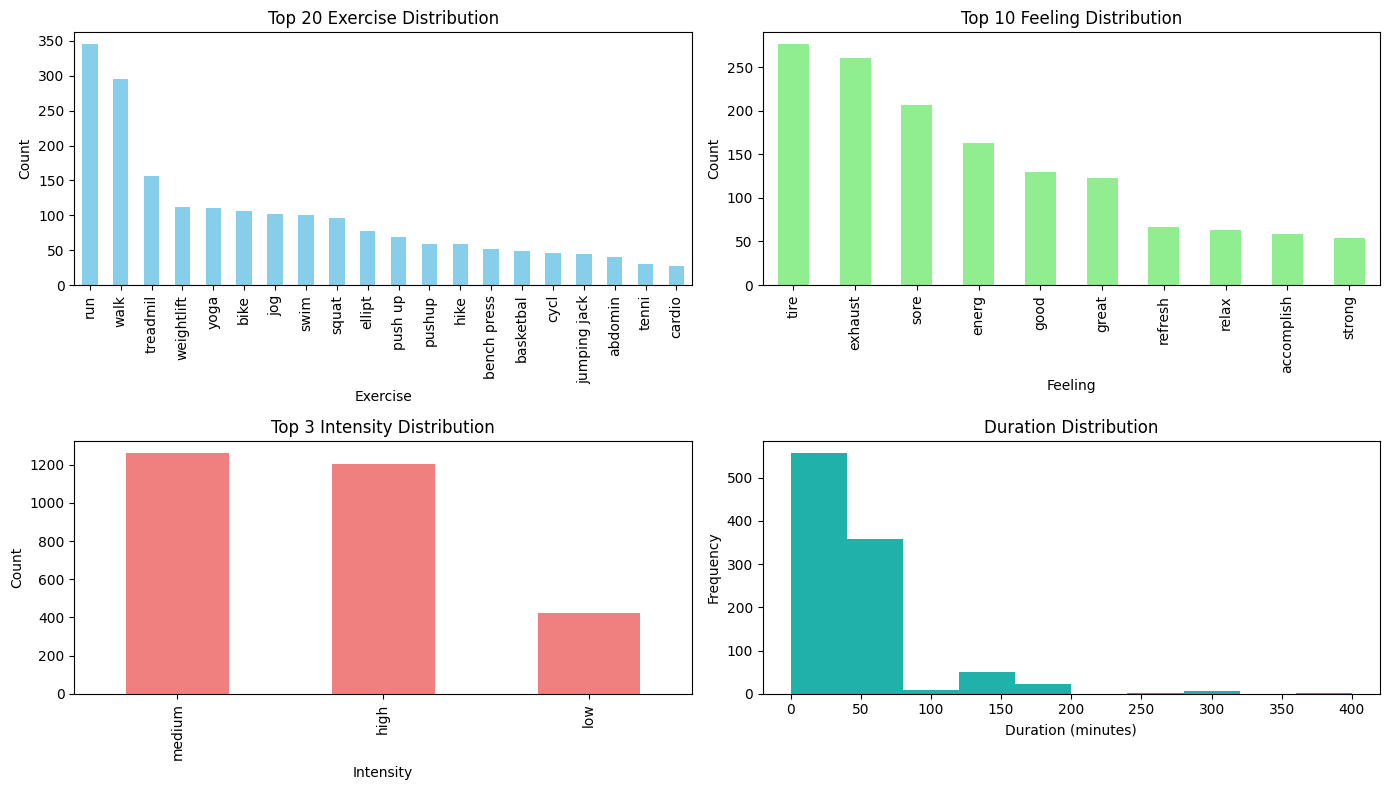

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


# Function to get top N elements in a list
def get_top_n_elements(counter, n=3):
    return counter.most_common(n)

# Extracting insights
def extract_insights(df):
    # Count occurrences of each tag
    exercise_counts = Counter(df['predicted_exercise_tags'])
    feeling_counts = Counter(df['predicted_feeling_tags'])
    intensity_counts = Counter(df['predicted_intensities'])
    # Use df_filtered for duration counts since this is where 'predicted_durations_mins' exists
    duration_counts = Counter(df_filtered['predicted_durations_mins']) # Change is here

    # Calculate average duration
    avg_duration = df_filtered['predicted_durations_mins'].mean() # Change is here

    # Get top exercises, feelings, and intensities
    top_exercises = get_top_n_elements(exercise_counts)
    top_feelings = get_top_n_elements(feeling_counts)
    top_intensities = get_top_n_elements(intensity_counts)

    insights = {
        'top_exercises': top_exercises,
        'top_feelings': top_feelings,
        'top_intensities': top_intensities,
        'average_duration': avg_duration
    }

    return insights

# Get insights from the dataframe
# Pass df_filtered to extract_insights since this is where 'predicted_durations_mins' exists
insights = extract_insights(df_filtered) # Change is here

# Print insights
print("Top Exercises:", insights['top_exercises'])
print("Top Feelings:", insights['top_feelings'])
print("Top Intensities:", insights['top_intensities'])
print("Average Duration:", insights['average_duration'])

# Visualizing the insights
def plot_insights(df):
    plt.figure(figsize=(14, 8))

    # Get the top 20 exercise tags
    top_20_exercise_tags = df_prediction['predicted_exercise_tags'].value_counts().nlargest(20)

    # Plot exercise tag distribution
    plt.subplot(2, 2, 1)
    top_20_exercise_tags.plot(kind='bar', color='skyblue')
    plt.title('Top 20 Exercise Distribution')
    plt.xlabel('Exercise')
    plt.ylabel('Count')


    # Get the top 10 feeling tags
    top_10_feeling_tags = df_prediction['predicted_feeling_tags'].value_counts().nlargest(10)

    # Plot top 20 feeling tag distribution
    plt.subplot(2, 2, 2)
    top_10_feeling_tags.plot(kind='bar', color='lightgreen')
    plt.title('Top 10 Feeling Distribution')
    plt.xlabel('Feeling')
    plt.ylabel('Count')

    # Get the top 3 intensities
    top_3_intensities = df_prediction['predicted_intensities'].value_counts().nlargest(3)

    # Plot top 3 intensity distribution
    plt.subplot(2, 2, 3)
    top_3_intensities.plot(kind='bar', color='lightcoral')
    plt.title('Top 3 Intensity Distribution')
    plt.xlabel('Intensity')
    plt.ylabel('Count')

    # Plot duration distribution with a spread of 0-400 minutes
    plt.subplot(2, 2, 4)
    # Assuming 'predicted_durations_mins' exists in df_filtered
    df_filtered['predicted_durations_mins'].plot(kind='hist', bins=10, range=(0, 400), color='lightseagreen')
    plt.title('Duration Distribution')
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plot the insights
# Pass df_filtered to plot_insights since this is where 'predicted_durations_mins' exists
plot_insights(df_filtered) # Change is here

In [ ]:
df_filtered

In [ ]:
# Get unique values from 'predicted_feeling_tags' column and create a DataFrame
unique_feelings = pd.DataFrame({'feeling': df_filtered['predicted_feeling_tags'].unique()})


In [ ]:
unique_feelings[]

In [ ]:
# prompt: Using dataframe unique_feelings: add another column 'sentiment' default to positive

# Adding a new column 'sentiment' and setting the default value to 'positive'
unique_feelings['sentiment'] = 'positive'

In [ ]:
# prompt: unique_feelings to csv

unique_feelings.to_csv('unique_feelings.csv', index=False)


In [ ]:

path = '/content/drive/MyDrive/pcems/unique_feelings.csv'
unique_feelings_new = pd.read_csv(path)
unique_feelings_new.head()


,feeling,sentiment
0,happi,positive
1,fatigu,positive
2,out of shap,negative
3,good,positive
4,hard,negative


In [ ]:
# prompt: in df_filtered add sentiment column with values matching sentiment in unique_feelings_new for the predicted_feeling_tags column

# Merge the two DataFrames on the 'predicted_feeling_tags' and 'feeling' columns
df_filtered = df_filtered.merge(unique_feelings_new, left_on='predicted_feeling_tags', right_on='feeling', how='left')

# Drop the 'feeling' column as it's redundant after the merge
df_filtered = df_filtered.drop('feeling', axis=1)

df_filtered


**Feeling Distribution by Exercise Type:**

Examine how different exercises affect feelings. For instance, do certain exercises tend to make people feel more "energized" while others make them feel "tired"?

<Figure size 1400x800 with 0 Axes>

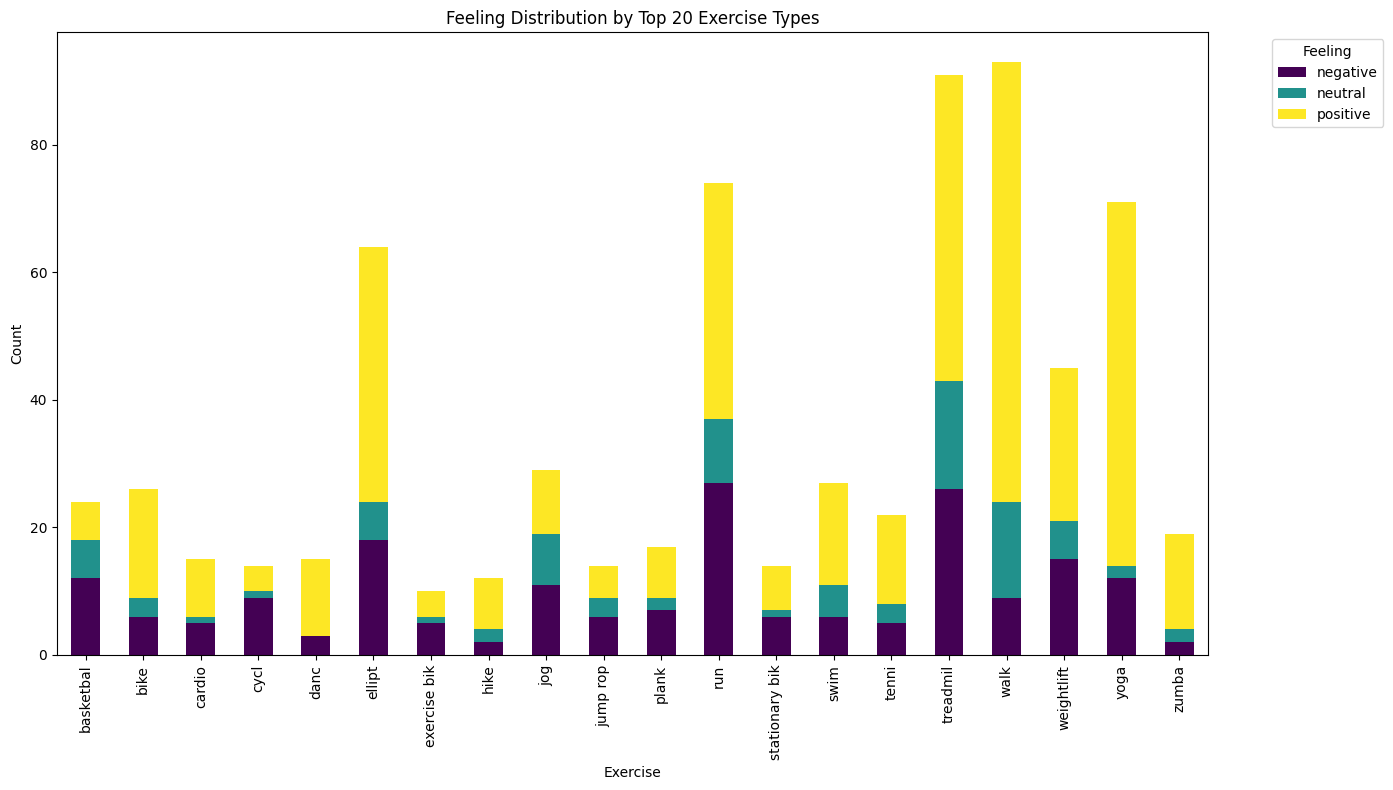

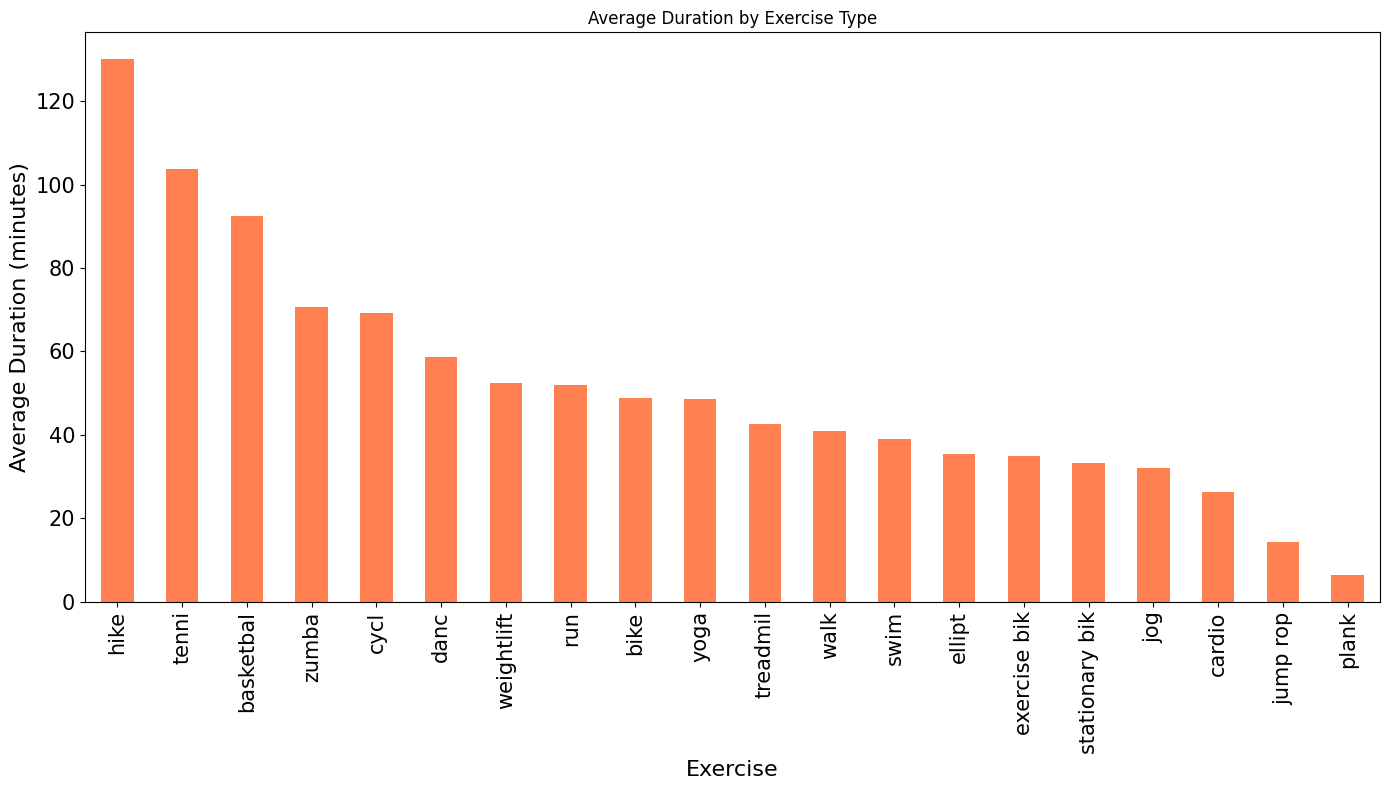

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Function to plot feeling distribution by top 20 exercise types
def plot_feeling_distribution_by_exercise(df, top_n=20):
    plt.figure(figsize=(14, 8))

    # Get the top N exercises
    top_exercises = df['predicted_exercise_tags'].value_counts().nlargest(top_n).index

    # Filter the dataframe to include only the top exercises
    df_top_exercises = df[df['predicted_exercise_tags'].isin(top_exercises)]

    # Plot the feeling distribution
    exercise_feeling_counts = df_top_exercises.groupby(['predicted_exercise_tags', 'sentiment']).size().unstack().fillna(0)
    exercise_feeling_counts.plot(kind='bar', stacked=True, colormap='viridis', figsize=(14, 8))

    plt.title(f'Feeling Distribution by Top {top_n} Exercise Types')
    plt.xlabel('Exercise')
    plt.ylabel('Count')
    plt.legend(title='Feeling', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Function to plot average duration for each exercise type
def plot_avg_duration_by_exercise(df, top_n=20):
    plt.figure(figsize=(14, 8))
    # Get the top N exercises
    top_exercises = df['predicted_exercise_tags'].value_counts().nlargest(top_n).index
    # Filter the dataframe to include only the top exercises
    df_top_exercises = df[df['predicted_exercise_tags'].isin(top_exercises)]
    avg_duration_by_exercise = df_top_exercises.groupby('predicted_exercise_tags')['predicted_durations_mins'].mean().nlargest(20)
    avg_duration_by_exercise.plot(kind='bar', color='coral')
    plt.title('Average Duration by Exercise Type')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Exercise', fontsize=16)
    plt.ylabel('Percentage', fontsize=16)
    plt.xlabel('Exercise')
    plt.ylabel('Average Duration (minutes)')
    plt.tight_layout()
    plt.show()

# Convert durations to numeric if not already done
df_filtered['predicted_durations_mins'] = pd.to_numeric(df_filtered['predicted_durations_mins'], errors='coerce')

# Plot feeling distribution by exercise type
plot_feeling_distribution_by_exercise(df_filtered)

# Plot average duration for each exercise type
plot_avg_duration_by_exercise(df_filtered)


<Figure size 1400x800 with 0 Axes>

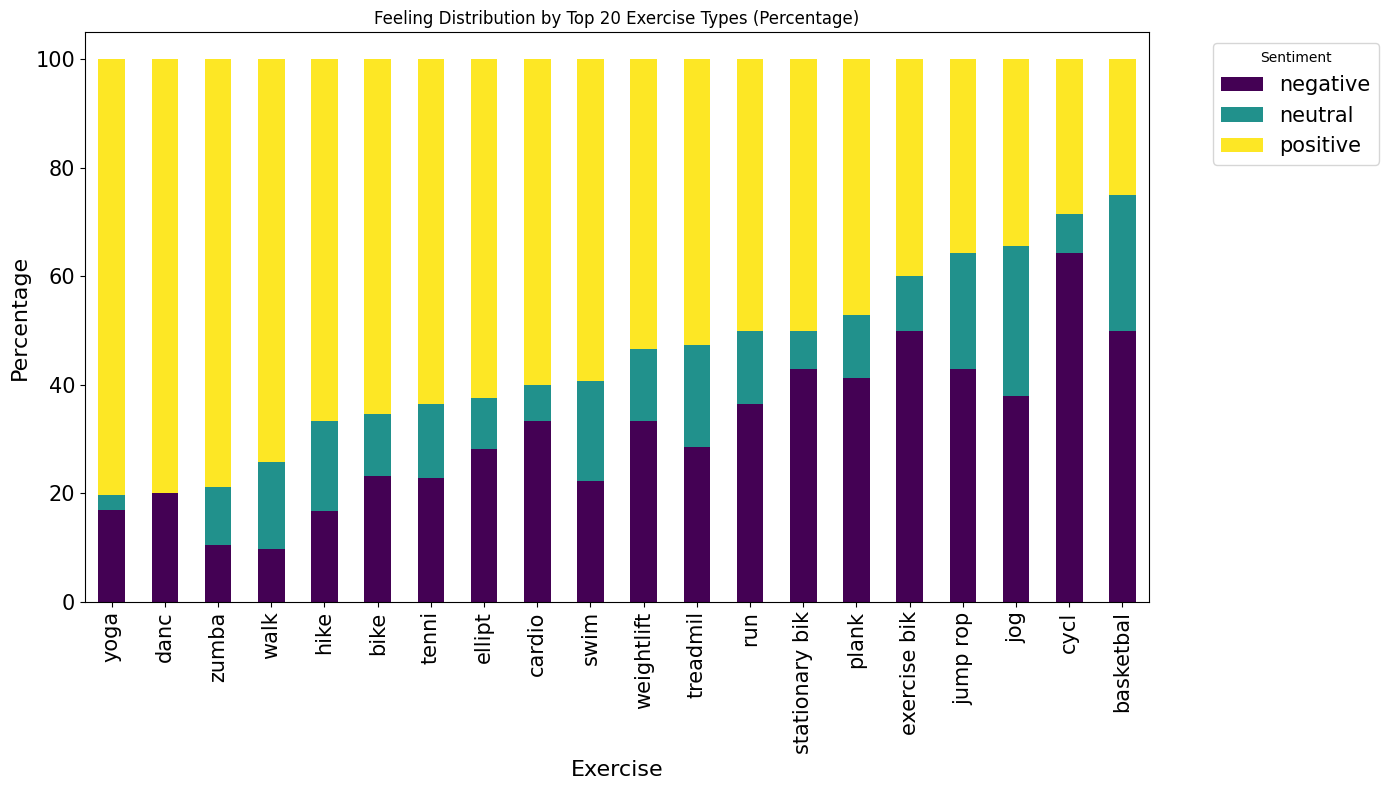

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to plot feeling distribution by top 20 exercise types
def plot_feeling_distribution_by_exercise(df, top_n=20):
    plt.figure(figsize=(14, 8))

    # Get the top N exercises
    top_exercises = df['predicted_exercise_tags'].value_counts().nlargest(top_n).index

    # Filter the dataframe to include only the top exercises
    df_top_exercises = df[df['predicted_exercise_tags'].isin(top_exercises)]

    # Calculate the count of feelings by exercise type
    exercise_feeling_counts = df_top_exercises.groupby(['predicted_exercise_tags', 'sentiment']).size().unstack().fillna(0)

    # Calculate the percentage of each feeling within each exercise type
    exercise_feeling_percentage = exercise_feeling_counts.div(exercise_feeling_counts.sum(axis=1), axis=0) * 100

    # Check if 'positive' column exists in the DataFrame
    if 'positive' in exercise_feeling_percentage.columns:
        # Sort the exercises by the percentage of positive sentiment in descending order
        positive_percentage = exercise_feeling_percentage['positive']
        sorted_exercises = positive_percentage.sort_values(ascending=False).index
        exercise_feeling_percentage = exercise_feeling_percentage.loc[sorted_exercises]
    else:
        print("No 'positive' sentiment found in the data.")
        return

    # Plot the feeling distribution as percentage
    exercise_feeling_percentage.plot(kind='bar', stacked=True, colormap='viridis', figsize=(14, 8))

    plt.title(f'Feeling Distribution by Top {top_n} Exercise Types (Percentage)')
    plt.xlabel('Exercise', fontsize=16)
    plt.ylabel('Percentage', fontsize=16)

    # Increase the font size of the legend
    plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 15})

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()
    # Increase the font size of exercise labels on x-axis



# Convert durations to numeric if not already done
df_filtered['predicted_durations_mins'] = pd.to_numeric(df_filtered['predicted_durations_mins'], errors='coerce')

# Plot feeling distribution by exercise type
plot_feeling_distribution_by_exercise(df_filtered)
